# Video System Repository

## A Little Aura

First, we'll introduce a function to control the length of our videos after they've been generated. As we'll see in the notebook, our model is limited by how many frames can be generated, so we'll need to extend the length.

In [6]:
from moviepy.editor import VideoFileClip, vfx

def adjust_fps(in_path, out_path):
    FPS = 8
    DURATION_CHANGE = 0.25

    clip = VideoFileClip(in_path)
    clip = clip.fx(vfx.speedx, factor=DURATION_CHANGE)
    clip.write_videofile(out_path, fps=FPS)

Here's basic example of how we can use the `maxin-cn/Latte-1` model to generate video.

In [7]:
import time
from videosys import LatteConfig, VideoSysEngine


def aura_example(steps, longer_vids, *args):
    STORAGE_PATH = "/disk/onyx-scratch/dullo009-fall2024"
    outputs = []
    logs = []

    cold_start_time = time.time()
    
    config = LatteConfig("maxin-cn/Latte-1",
        enable_pab=True, 
        num_gpus=8
    )
    engine = VideoSysEngine(config)
    
    cold_start_duration = time.time() - cold_start_time
    logs.append(f"Cold-start time: {cold_start_duration:.4f} seconds")

    for emotion in args:
        iteration_start_time = time.time()
        
        prompt = f"Create abstract art with swirls, curves, color, and shapes which represent the following emotion: {emotion}"
        video = engine.generate(
            prompt,
            num_inference_steps=steps
        ).video[0]
        input_path = f"{STORAGE_PATH}/art/aura_test_{emotion}_art.mp4"
        output_path = f"{STORAGE_PATH}/art/aura_test_{emotion}_art_slowed.mp4"
        engine.save_video(video, input_path)
        
        if longer_vids:
            adjust_fps(input_path, output_path)
            outputs.append(output_path)
        else:
            outputs.append(input_path)

        iteration_duration = time.time() - iteration_start_time
        logs.append(f"Time for '{emotion}' iteration: {iteration_duration:.4f} seconds")
    return outputs, logs

Let's try our model on a single emotion - "happiness". We won't shorten the video to start and have a 50 denoising steps.

In [9]:
import time
from IPython.display import HTML, clear_output
from base64 import b64encode
import os

def display_videos(video_paths):
    for path in video_paths:
        if not os.path.exists(path):
            video_paths.remove(path)
    
    videos = []
    for path in video_paths:
        with open(path, "rb") as video_file:
            video_encoded = b64encode(video_file.read()).decode('utf-8')
            videos.append(video_encoded)
    
    clear_output(wait=True)
    video_html = ''.join([f'''
        <video width="512" height="512" controls autoplay loop>
            <source src="data:video/mp4;base64,{video}" type="video/mp4">
        </video>
    ''' for video in videos])

    # Display all videos
    display(HTML(video_html))

outputs, logs = aura_example(50, False, "happiness")
display_videos(outputs)
print("\n".join(logs))

Cold-start time: 20.0742 seconds
Time for 'happiness' iteration: 46.1179 seconds


As you can see above, the time it takes to generate this first clip is pretty long - ~42.02 seconds. Too long, especially given a 2 second clip. This "aura" wouldn't be generated in real time - but let's like at some more examples.

In [4]:
emotions = ["joy", "anger", "sadness", "fear", "disgust"]
outputs, logs = aura_example(50, False, *emotions)
display_videos(outputs)
print("\n".join(logs))

Cold-start time: 21.9567 seconds
Time for 'joy' iteration: 71.3567 seconds
Time for 'anger' iteration: 54.1335 seconds
Time for 'sadness' iteration: 54.6330 seconds
Time for 'fear' iteration: 54.6828 seconds
Time for 'disgust' iteration: 54.1451 seconds


We do see something important - after the initial generation, we no longer face the cold-start time penalty which happens when the "shards" are loaded into memory. Example loading shards output:

```
Downloading shards: 100%|██████████| 4/4 [00:00<00:00, 5845.72it/s]
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]
```

Granted, even if we don't experience that 23.67s penalty for every generation, the roughly 20 seconds for each 2 second clip is way too much. Let's try and do some clever tricks to make this "real time".

In [10]:
emotions = ["joy", "anger", "sadness", "fear", "disgust"]
outputs, logs = aura_example(30, True, *emotions)
display_videos(outputs)
print("\n".join(logs))

Cold-start time: 24.0034 seconds
Time for 'joy' iteration: 37.6707 seconds
Time for 'anger' iteration: 16.1746 seconds
Time for 'sadness' iteration: 16.2902 seconds
Time for 'fear' iteration: 16.2561 seconds
Time for 'disgust' iteration: 16.3701 seconds


Video generation should now be lower than 8 seconds - around 4 or 5 seconds. This is thanks to decreasing the number of denoising steps, `steps` and artificially increasing the video lengths (but not changing the number of frames generated) w/ `longer_vids`.

Depending on the current load on the GPUs (from other users), this could fluctuate rapidly, but in optimal conditions this demo should work. In bad conditions, the video generation does take around 35 seconds per video even after our length increasing tricks.

# Watching Yourself Over the Internet

To simulate the streaming process, you will need to run two different processes: the streamer and the aura server.

* The **Streamer** continously pushes `jpeg` images through a socket with a specified port (by defauly, in this example, 6000). These `jpeg` images are captured through the opencv library's camera functionality. We need to listen in on that output and do some kind of processing - in our demo, changing the video to black and white. 
* The **Receiver** will be the one listening in on this port, still through web sockets and receiving the frames. After we have a frame, we do the pre-processing and send the modified frames back to the streamer. 

## Caveats

While this streaming is similar to the final flow of Aura, it still isn't fully featured. The next step is to create a queue for when multiple users want to connect to Aura.

## Starting the Stream

The first step is to create an SSH tunnel between your machine and Onyx. This allows your video streaming program to send information to Aura over a specific port. The follow command does that with the port 6000:

```
ssh -N -L 6000:localhost:6000 your_username@onyx.cs.fiu.edu
```

Once you have this created, you should see a small prompt that you've successfully authenticated into onyx. So long as you have that terminal running, you have an open SSH tunnel. Now onto running the streaming code, which is in the following code cell. **For preface, this code must be run on your local machine** and "receiver" code (or other logic specific to generating video) must be ran on onyx.

These are the ports mentioned above - if you need to change them for your own needs, feel free here:

In [2]:
HOST = '0.0.0.0'
PORT = 6000
server_type = input("Do you want to run the receiver or sender? (r/s)")

One last thing to note before running the code: this is the order in which these steps must be taken:
* Create SSH Tunnel
* Start Receiver
* Start Sender

### Receiver

In [3]:
import socket
import struct
import cv2
import numpy as np


def process_frame(frame):
    """
    Example processing: convert to grayscale
    In Aura, this would be using the frame to generate the video
    """
    processed_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_GRAY2BGR)
    return processed_frame

def receive():
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind((HOST, PORT))
        s.listen(1)
        print('Server listening on port', PORT)
        conn, addr = s.accept()
        print('Connected by', addr)
        with conn:
            while True:
                # Receive the size of the frame data
                data_size_packed = conn.recv(4)
                if not data_size_packed:
                    break
                data_size = struct.unpack(">L", data_size_packed)[0]

                # Receive the frame data
                data = b''
                while len(data) < data_size:
                    packet = conn.recv(data_size - len(data))
                    if not packet:
                        break
                    data += packet

                if not data:
                    break

                # Decode the image
                nparr = np.frombuffer(data, np.uint8)
                frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

                # Process the frame
                processed_frame = process_frame(frame)

                # Encode the processed frame
                result, processed_encoded = cv2.imencode('.jpg', processed_frame)
                processed_data = processed_encoded.tobytes()

                # Send back the size of the processed data
                conn.sendall(struct.pack(">L", len(processed_data)))
                # Send back the processed data
                conn.sendall(processed_data)

if len(server_type) != 0 and server_type[0] == "r":
    receive()

Server listening on port 6000
Connected by ('127.0.0.1', 47328)


### Sender

If ran correctly, you should see a video of yourself, watching youself on your local machine in black and white :)

In [6]:
import cv2
import time
import socket
import struct
import numpy as np

def encode_jpeg(frame) -> bytes:
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 90]
    _, frame_encoded = cv2.imencode('.jpg', frame, encode_param)
    return frame_encoded.tobytes()

def send():
    cap = cv2.VideoCapture(1)  # Open the default camera

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((HOST, PORT))
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            data = encode_jpeg(frame)

            # Send the size of the data, then the data
            s.sendall(struct.pack(">L", len(data)))
            s.sendall(data)

            # Receive the size of the processed frame data
            data_size_packed = s.recv(4)
            if not data_size_packed:
                break
            data_size = struct.unpack(">L", data_size_packed)[0]

            # Receive the processed frame data
            processed_data = b''
            while len(processed_data) < data_size:
                packet = s.recv(data_size - len(processed_data))
                if not packet:
                    break
                processed_data += packet

            if not processed_data:
                break

            # Decode the processed image
            nparr = np.frombuffer(processed_data, np.uint8)
            processed_frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            # Display the processed frame
            cv2.imshow('Processed Frame', processed_frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

if len(server_type) != 0 and server_type[0] == "s":
    send()

2024-10-31 14:21:17.835 Python[54846:999902] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


## Oh AGI, Give me a Dataset

In order to pass the images to our model (which only acceps text), we'll have GPT-4o describe the person's aura. Using this text and a prompt we prepare, our model can generate (hopefully) an accurate aura.

We'll use this image for our tests:

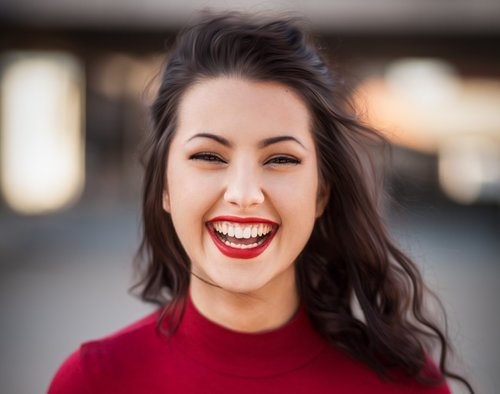

In [13]:
import requests
from PIL import Image
from io import BytesIO

url = 'https://images.squarespace-cdn.com/content/v1/5811246737c581e3d863f020/1514670194571-9YWHQITTW2PJ2M4RMZFY/Happiest+person+in+the+world%21.jpg?format=500w'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

img.show()

In [21]:
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

client = OpenAI(api_key = os.getenv("OPENAI_API_KEY"))

response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "Can you describe the image?"},
        {
          "type": "image_url",
          "image_url": {
            "url": url
          },
        },
      ],
    }
  ],
  max_tokens=300,
)

print(response.choices[0].message.content)

The image features a young woman with long, dark hair, smiling broadly. She is wearing a red top, and her lips are also painted red, complementing her cheerful expression. The background appears to be somewhat blurred, suggesting an outdoor setting. Her joyful demeanor and bright smile convey a sense of happiness and confidence.


This comes out pretty well, but let's generate some text that's useful to generating an aura.

In [31]:
import base64

load_dotenv()

def fetch_image(url):
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Could not fetch image at {url}, returned status {response.status_code}")
    img = Image.open(BytesIO(response.content))
    buffered = BytesIO()
    format = img.format if img.format else 'JPEG'
    img.save(buffered, format=format)
    bytes = buffered.getvalue()
    return base64.b64encode(bytes).decode('utf-8')


def caption_aura_image(image):
    client = OpenAI(api_key = os.getenv("OPENAI_API_KEY"))

    prompt = """Your task is to describe the emotion of the person in the provided image.
    Keep your answer to a sentence and without preamble - every word of your answer will be used to understand the aura of the person."""

    response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt},
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{image}"
            },
            },
        ],
        }
    ],
    max_tokens=300,
    )

    return response.choices[0].message.content

image = fetch_image(url)
caption_aura_image(image)

'The person exudes joyful exuberance with a radiant, genuine smile.'

Let's try with some more examples...

In [35]:
def display_image_captions(image_urls, captions) -> None:

    if len(image_urls) != len(captions):
        raise ValueError("The number of image URLs must match the number of captions.")

    html_content = ""
    for url, caption in zip(image_urls, captions):
        html_content += f"""
        <div style="text-align: center; margin-bottom: 20px;">
            <img src="{url}" alt="{caption}" style="max-width: 100%; height: auto;">
            <p style="font-style: italic;">{caption}</p>
        </div>
        <hr>
        """

    display(HTML(html_content))

images = [
    "https://images.unsplash.com/photo-1609852234838-147db6815968?q=80&w=512&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
    "https://images.unsplash.com/photo-1609852234838-147db6815968?q=80&w=512&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
    "https://images.unsplash.com/photo-1583264277139-3d9682e44b03?q=80&w=512&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
    "https://images.unsplash.com/photo-1527389123978-53405521c094?q=80&w=512&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
    "https://images.unsplash.com/photo-1603815671596-31aa538d8809?q=80&w=512&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
    "https://images.unsplash.com/photo-1667053508464-eb11b394df83?q=80&w=512&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
    "https://plus.unsplash.com/premium_photo-1661411095757-e85b9bf85ba7?q=80&w=512&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
]

aura_captions = []
for link in images:
    image = fetch_image(link)
    aura_captions.append(caption_aura_image(image))

display_image_captions(images, aura_captions)

## Putting it All Together

In [ ]:
def aura(*args) -> str:
    cold_start_time = time.time()
    
    config = LatteConfig("maxin-cn/Latte-1",
        enable_pab=True, 
        num_gpus=8
    )
    engine = VideoSysEngine(config)

    prompt = f"Create abstract art with swirls, curves, color, and shapes which represent the following emotion: {emotion}"
    video = engine.generate(
        prompt,
        num_inference_steps=30
    ).video[0]
    input_path = f"{STORAGE_PATH}/art/aura_test_{emotion}_art.mp4"
    output_path = f"{STORAGE_PATH}/art/aura_test_{emotion}_art_slowed.mp4"
    engine.save_video(video, input_path)
    
    adjust_fps(input_path, output_path)
    return output_path